In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import MDS
import seaborn as sns         
import numpy as np


def plot_mds(original, gan):
    import seaborn as sns
    sns.set_theme(style="ticks", palette="pastel")
    
    # Matplotlib settings
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
    sns.scatterplot(x=gan[:, 0], y=gan[:, 1], data=gan, color="g")
    sns.scatterplot(x=original[:, 0], y=original[:, 1], data=original, color="b")
    sns.despine(offset=10, trim=True)

    # Perfumaria
    ax.set_xlabel("X component")
    ax.set_ylabel("Y component")
    ax.set_title("Multidimensional scaling")
    #plt.legend(["Proposed workflow", "Traditional workflow"])
    #plt.savefig("data/results/mds.png", dpi=500, bbox_inches='tight')


def mds_plots(snesim_realizations_path, gan_realizations_path):
    traditional = np.load(snesim_realizations_path).reshape((100, -1))
    proposed = np.load(gan_realizations_path).reshape((100, -1))

    mds = MDS(n_components=2, metric=True, random_state=0)
    # Get the embeddings
    original = mds.fit_transform(
        np.load("snesim/data/realizations.npy").reshape((100, -1))
        )

    # Get the embeddings
    gan = mds.fit_transform(
        np.load("generative_model/data/realizations.npy").reshape((100, -1))
        )

    plot_mds(original, gan)

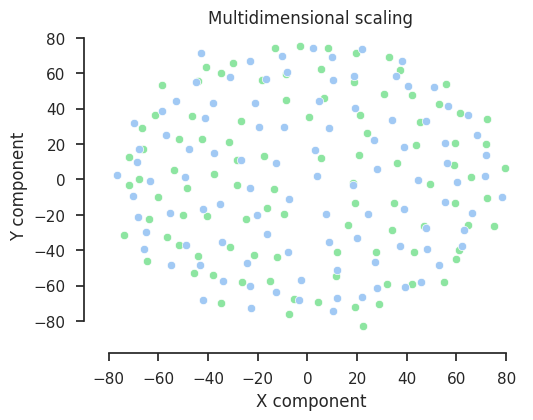

In [61]:
mds_plots(snesim_realizations_path="snesim/data/realizations.npy",
            gan_realizations_path="generative_model/data/realizations.npy")

In [6]:
snesim_realizations = np.load("snesim/data/realizations.npy").reshape((100, -1))
gan_realizations = np.load("generative_model/data/realizations.npy").reshape((100, -1))

AttributeError: 'AxesSubplot' object has no attribute 'colorbar'

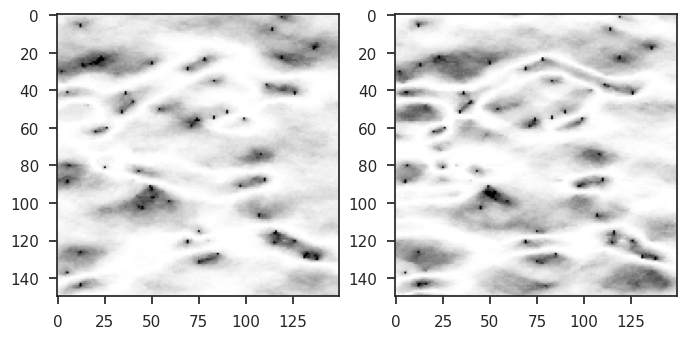

In [90]:
fig, ax = plt.subplots(1, 2)

# pensar com calma

vmin = min(gan_realizations.std(axis=0).min(), snesim_realizations.std(axis=0).min())
vmax = max(gan_realizations.std(axis=0).max(), snesim_realizations.std(axis=0).max())

ax[0].imshow(gan_realizations.std(axis=0).reshape(150,150), 'gray', vmin=vmin, vmax=vmax)
ax[1].imshow(snesim_realizations.std(axis=0).reshape(150,150), 'gray',vmin=vmin, vmax=vmax)

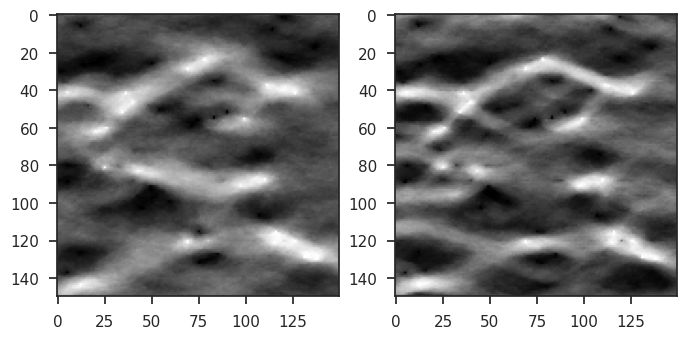

In [91]:
fig, ax = plt.subplots(1, 2)

# pensar com calma

vmin = min(gan_realizations.mean(axis=0).min(), snesim_realizations.mean(axis=0).min())
vmax = max(gan_realizations.mean(axis=0).max(), snesim_realizations.mean(axis=0).max())

ax[0].imshow(gan_realizations.mean(axis=0).reshape(150,150), 'gray', vmin=vmin, vmax=vmax)
ax[1].imshow(snesim_realizations.mean(axis=0).reshape(150,150), 'gray',vmin=vmin, vmax=vmax)

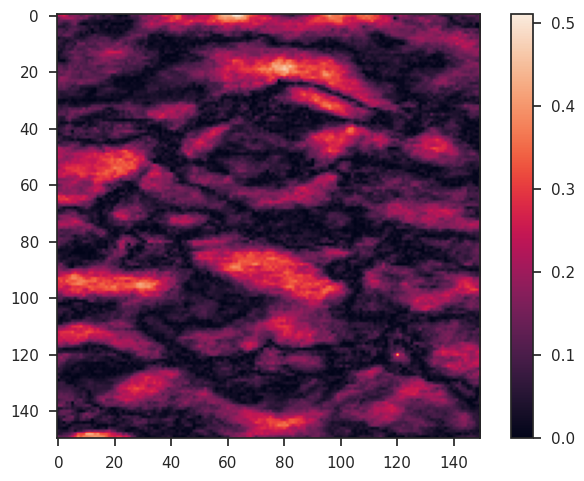

In [93]:
plt.imshow(np.abs(gan_realizations.mean(axis=0).reshape(150,150) - snesim_realizations.mean(axis=0).reshape(150,150)))
plt.colorbar()

## Get PCA components that explain 80% of the dataset variance

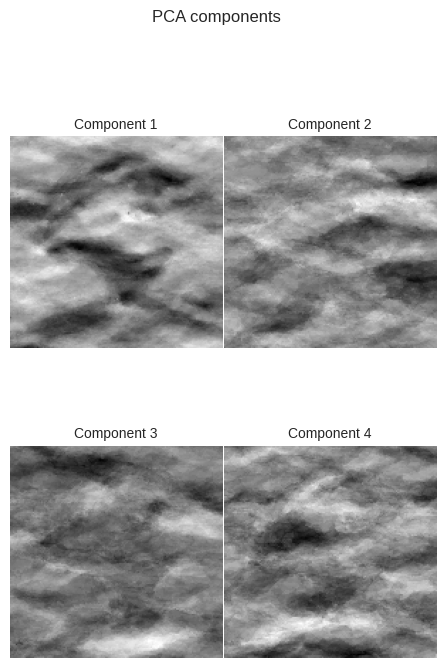

In [124]:
from sklearn.decomposition import PCA
# n_components=0.80 means it will return the Eigenvectors that have the 80% of the variation in the dataset

faces_pca = PCA(n_components=0.8)
faces_pca.fit(gan_realizations)
fig, axes = plt.subplots(2, 2, figsize=(5.5, 8),
    subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.010, wspace=0.010))

plt.suptitle("PCA components")
for i, ax in enumerate(axes.flat):
    ax.set_title(f"Component {i+1}", fontsize=10)
    ax.imshow(faces_pca.components_[i].reshape(150, 150),cmap="binary")

## Boxplot with standard deviation differences

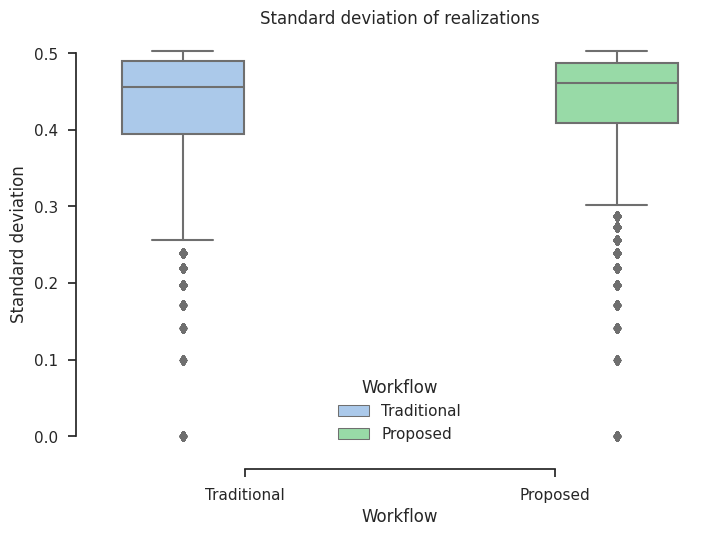

In [25]:
import pandas as pd

ti_dict = dict()
for idx, realization in enumerate(snesim_realizations):
    ti_dict[f'ti_{idx+1}'] = np.array(realization.reshape(-1))

snesim_dataframe = pd.DataFrame(ti_dict)

ti_dict = dict()
for idx, realization in enumerate(gan_realizations):
    ti_dict[f'ti_{idx+1}'] = np.array(realization.reshape(-1))

gan_dataframe = pd.DataFrame(ti_dict)

# Add category
snesim_dataframe['Standard deviation'] = snesim_dataframe.std(axis=1)
snesim_dataframe['Workflow'] = "Traditional"

gan_dataframe['Standard deviation'] = gan_dataframe.std(axis=1)
gan_dataframe['Workflow'] = "Proposed"

fig, ax = plt.subplots()

import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
cdf = pd.concat([snesim_dataframe, gan_dataframe])

# Draw boxplot
plt.title("Standard deviation of realizations")
sns.boxplot(x='Workflow', y='Standard deviation',hue="Workflow", palette=["b", "g"],
            data=cdf)
sns.despine(offset=10, trim=True)

## Get optimum `n_components`

/home/lpm/gan-for-mps/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


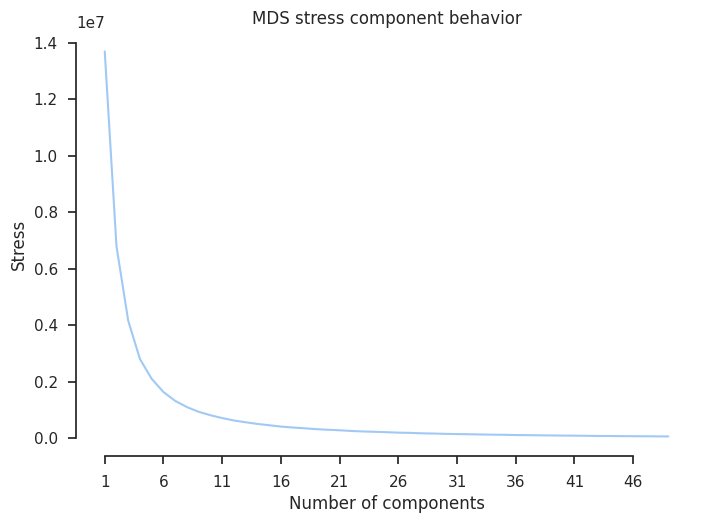

In [69]:
stress = []
# Max value for n_components
max_range = 50
for dim in range(1, max_range):
    # Set up the MDS object
    mds = MDS(n_components=dim, random_state=0)
    # Apply MDS
    pts = mds.fit_transform(
        np.load("snesim/data/realizations.npy").reshape((100, -1))
        )
    # Retrieve the stress value
    stress.append(mds.stress_)

# Plot stress vs. n_components 
plt.xticks(range(1, max_range, 5))
plt.xlabel('Number of components')
plt.ylabel('Stress')
plt.title("MDS stress component behavior")
sns.lineplot(range(1, max_range), stress)
sns.despine(offset=0.5, trim=True)

plt.show()